# WSO Retention Model- lightgbm
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* May 18, 2022

## Hypothesis
This notebook will test the standard StellarAlgo retention model features and the goal is to check if our standard retention model works for WSO or not and how our accuracy and scores look. We are also checking if we have enough data for training the retention model effectively.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [1]:
import boto3
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

from pycaret.classification import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

### To connect to RedShift, we have to tell AWS which profile we'd like to login to, this will send us for a browser authentication trip:

In [2]:
! aws sso login --profile Stellaralgo-DataScienceAdmin

Attempting to automatically open the SSO authorization page in your default browser.
If the browser does not open or you wish to use a different device to authorize this request, open the following URL:

https://device.sso.us-east-1.amazonaws.com/

Then enter the code:

QDCK-PDXV
Successully logged into Start URL: https://stellaralgo.awsapps.com/start#/


### Now we can create a session and client to RedShift, and create a new connection using Psycopg2:

In [3]:
session = boto3.session.Session(profile_name='Stellaralgo-DataScienceAdmin')
client = session.client('redshift')

CLUSTER = 'qa-app'
DBNAME = 'stlrwso'

creds = client.get_cluster_credentials(                
    ClusterIdentifier = CLUSTER,
    DbUser = 'admin',
    DbName = DBNAME,
    DbGroups = ['admin_group'],
    AutoCreate=True
)

print(f"GOT CONNECTION TO DATABASE: {CLUSTER} {DBNAME}")

GOT CONNECTION TO DATABASE: qa-app stlrwso


### First we need to call the stored procedure, which will create a named cursor - then we can query the results produced by the stored proc using that named cursor:

In [4]:
# create a connection & cursor and call the stored procedure
conn = psycopg2.connect(
    host = 'qa-app.ctjussvyafp4.us-east-1.redshift.amazonaws.com',
    port = 5439,
    user = creds['DbUser'],
    password = creds['DbPassword'],
    database = DBNAME
)

cur = conn.cursor()
cur.execute(f"CALL dw.getretentionmodeldata(14, 2010, 2021, 'rkcursor')")

# create a named cursor based on the cursor name passed in above
named_cursor = conn.cursor('rkcursor')
data = named_cursor.fetchall()

# load the data and columns into a data frame
cols = [row[0] for row in named_cursor.description]
df = pd.DataFrame(data=data, columns=cols)

conn.commit()

In [5]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12251 entries, 0 to 12250
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   lkupclientid         12251 non-null  int64         
 1   dimcustomermasterid  12251 non-null  int64         
 2   year                 12251 non-null  int64         
 3   productgrouping      12251 non-null  object        
 4   totalspent           12251 non-null  float64       
 5   recentdate           12251 non-null  datetime64[ns]
 6   attendancepercent    12251 non-null  float64       
 7   renewedbeforedays    12251 non-null  int64         
 8   source_tenure        12251 non-null  object        
 9   tenure               12251 non-null  int64         
 10  disttovenue          12251 non-null  float64       
 11  recency              12251 non-null  int64         
 12  missed_games_1       12251 non-null  object        
 13  missed_games_2       12251 non-

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,disttovenue,recency,missed_games_1,missed_games_2,missed_games_over_2,forward_records,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer
0,14,277984872,2016,Full Series,87.50,1970-01-01,0.40,207,2555,215,1083.04,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,0
1,14,296604868,2016,Full Series,62.50,1970-01-01,0.40,253,6935,261,34.23,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,1
2,14,278052813,2016,Full Series,377.52,1970-01-01,0.33,267,2920,275,1239.45,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,1
3,14,296599176,2016,Full Series,31.25,2016-08-21,0.60,219,4380,227,644.24,0,0,0,2,0,0.00,0.00,0.00,Unknown,0,0,1
4,14,278058958,2016,Mini Plan,131.68,1970-01-01,0.86,137,2190,140,1567.35,0,0,0,1,0,0.00,0.00,0.00,Unknown,0,0,0


In [6]:
df["productgrouping"].value_counts()

Full Series    7205
Mini Plan      5046
Name: productgrouping, dtype: int64

In [7]:
df["totalspent"].value_counts()

102.50      494
100.00      492
1730.24     450
120.00      322
150.00      298
           ... 
24901.12      1
1012.50       1
950.08        1
4860.00       1
2080.64       1
Name: totalspent, Length: 1201, dtype: int64

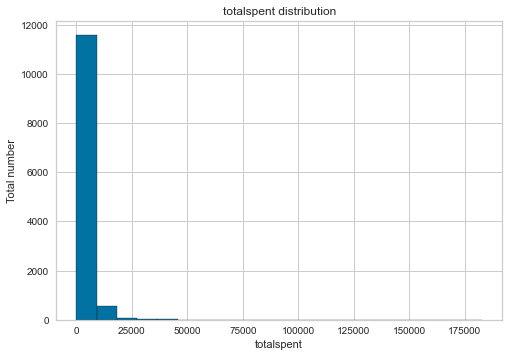

In [8]:
plt.hist(df["totalspent"], bins=20, edgecolor='black')
plt.title("totalspent distribution")
plt.ylabel("Total number")
plt.xlabel("totalspent")
plt.show()

In [9]:
df["attendancepercent"].value_counts()

0.75    1277
0.50    1207
1.00    1154
0.67     792
0.60     438
        ... 
1.04       1
0.14       1
0.06       1
1.20       1
0.02       1
Name: attendancepercent, Length: 112, dtype: int64

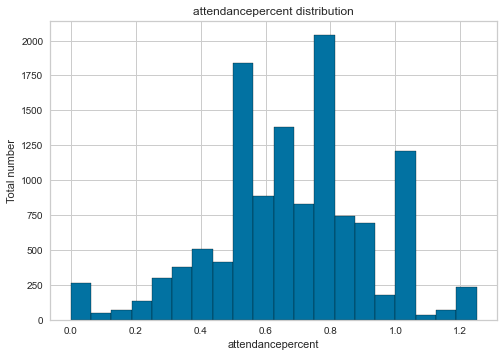

In [10]:
plt.hist(df["attendancepercent"], bins=20, edgecolor='black')
plt.title("attendancepercent distribution")
plt.ylabel("Total number")
plt.xlabel("attendancepercent")
plt.show()

In [11]:
df["renewedbeforedays"].value_counts()

 250    377
 243    359
 207    344
 255    319
 247    244
       ... 
 272      1
 216      1
 230      1
-1        1
-101      1
Name: renewedbeforedays, Length: 290, dtype: int64

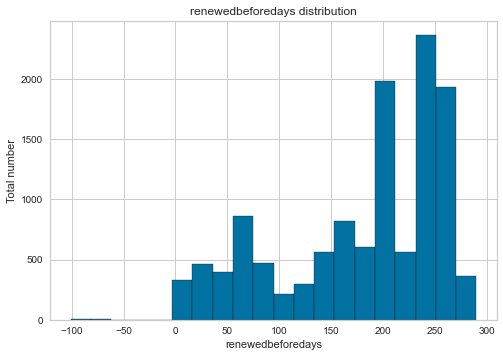

In [12]:
plt.hist(df["renewedbeforedays"], bins=20, edgecolor='black')
plt.title("renewedbeforedays distribution")
plt.ylabel("Total number")
plt.xlabel("renewedbeforedays")
plt.show()

### Let's see how much data we have for each year:

In [13]:
df["year"].value_counts().sort_index(ascending=False)

2021    2397
2019    2389
2018    2717
2017    2412
2016    2336
Name: year, dtype: int64

### We should specify the features used in our model:

In [14]:
# choose the features for the stellar base retention model
features = [
                "dimcustomermasterid",
                "attendancepercent",
                "totalspent",
                "source_tenure",
                "renewedbeforedays",
                "isnextyear_buyer",
                "productgrouping",
                "year"
]

# copy your main dataframe
df_dataset = df

# choose the features & train year & test year
df_dataset = df_dataset[features]
df_dataset["year"] = pd.to_numeric(df_dataset["year"])
df_dataset = df_dataset.loc[df_dataset["year"] <= 2019]

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True, inplace=True)
df_eval.reset_index(drop=True, inplace=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (8376, 8)
Unseen Data For Predictions: (1478, 8)



### Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [15]:
setup(
    data= df_train, 
    target="isnextyear_buyer", 
    train_size = 0.85,
    data_split_shuffle=True,
    ignore_features=["dimcustomermasterid","productgrouping","year"],
    silent=True,
    verbose=False,
    numeric_features=[
                "attendancepercent",
                "totalspent",
                "source_tenure"
                
    ]
);

In [16]:
model_matrix = compare_models(
    fold=10,
    include=[ "lightgbm"]
)
#   "rf", "xgboost"

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8095,0.8826,0.7580,0.8106,0.7829,0.6136,0.6153,0.2750


In [17]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8090,0.8834,0.7678,0.8026,0.7848,0.6132,0.6137
1,0.8160,0.8878,0.7337,0.8404,0.7835,0.6248,0.6291
2,0.7949,0.8675,0.7554,0.7846,0.7697,0.5850,0.5854
3,0.8244,0.8951,0.7740,0.8278,0.8000,0.6439,0.6450
4,0.8287,0.9051,0.7988,0.8190,0.8088,0.6536,0.6538
5,0.7963,0.8597,0.7152,0.8134,0.7611,0.5849,0.5886
6,0.8174,0.8839,0.7585,0.8249,0.7903,0.6291,0.6309
7,0.8188,0.8896,0.8204,0.7887,0.8042,0.6357,0.6362
8,0.7767,0.8592,0.7037,0.7835,0.7415,0.5459,0.5484
9,0.8129,0.8950,0.7523,0.8209,0.7851,0.6201,0.6219


### Let's load in our 2021 season data and get retention scores using the model:

In [18]:
df_inference = df.loc[df["year"] >= 2021]
df_inference = df_inference.fillna(0)
df_inference.shape

(2397, 23)

In [19]:
new_predictions = predict_model(final_model, data=df_inference, raw_score=True)
new_predictions.head()

,lkupclientid,dimcustomermasterid,year,productgrouping,totalspent,recentdate,attendancepercent,renewedbeforedays,source_tenure,tenure,...,opentosendratio,clicktosendratio,clicktoopenratio,gender,phonecall,inperson_contact,isnextyear_buyer,Label,Score_0,Score_1
382,14,296580881,2021,Mini Plan,288.0,1970-01-01,0.33,24,25,25,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9989,0.0011
383,14,296599593,2021,Full Series,12240.0,1970-01-01,1.02,68,76,76,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9986,0.0014
384,14,296599420,2021,Full Series,8600.0,1970-01-01,0.72,204,3285,2083,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.7875,0.2125
385,14,296599318,2021,Full Series,2500.0,2021-08-22,0.53,207,8760,2083,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.9370,0.0630
386,14,296600462,2021,Full Series,7000.0,1970-01-01,0.60,201,6205,2127,...,0.00,0.00,0.00,Unknown,0,0,0,0,0.5282,0.4718


In [20]:
new_predictions["Label"].value_counts()

0    2319
1      78
Name: Label, dtype: int64

In [21]:
new_predictions["Score_1"].value_counts(bins=[0, 0.4, 0.7, 1.0])

(-0.001, 0.4]    2252
(0.4, 0.7]        125
(0.7, 1.0]         20
Name: Score_1, dtype: int64

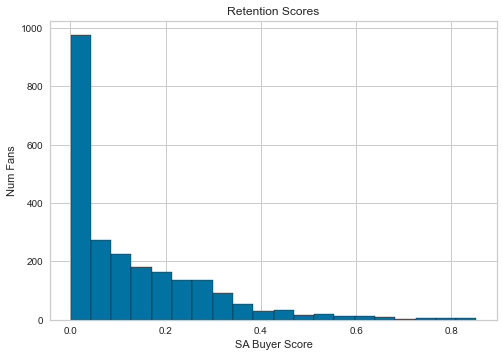

In [22]:
plt.hist(new_predictions["Score_1"], bins=20, edgecolor='black')
plt.title("Retention Scores")
plt.ylabel("Num Fans")
plt.xlabel("SA Buyer Score")
plt.show()

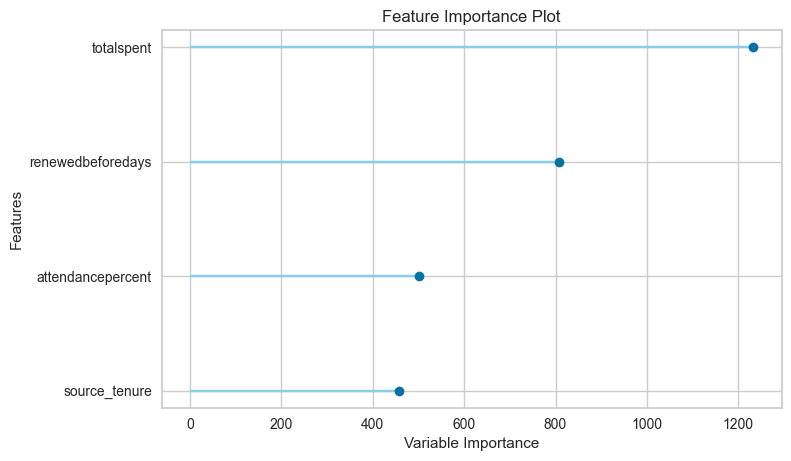

In [23]:
plot_model(best_model, plot='feature')

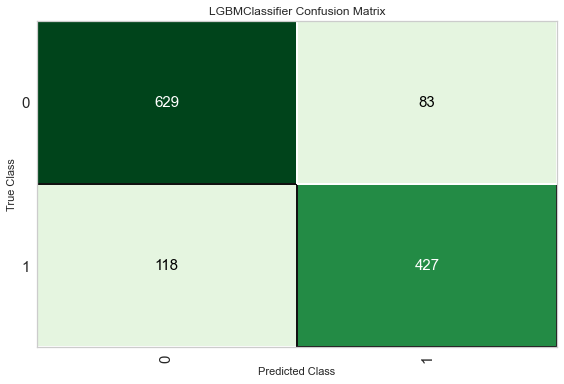

In [24]:
plot_model(best_model, plot='confusion_matrix')

### Observations:

1. How much data did we have available to train the model, was it enough data?
* We have 9,854 data for training (we selected data from 2016 to 2019 to train the model).

2. How accurate was our retention model when applied to this tennis tournament dataset?
* The accuracy is 80%, typically our retention model accuracy is over 90%.

3. How many fans scored over 0.75 for the 2021 season? How does this compare with a retention model for a regular season 
* We have 20 of 2397 fans that scored over 0.75 for the 2021 season which is low.
* typically our retention model scores the majority of fans over 0.5.

4. What were the most important features in making a correct model prediction? Do they make sense for a tennis tournament?

* Renewedbeforedays, totalspent, and attendancepercent are still important which makes sense in the context of a tennis tournament.


### Conclusion:

Based on our observations above we would not reccomend using this retention model for tournaments because eventhough it is 80% accurate it does not predict high enough number of buyers to be useful for the WSO.